## Mushroom classification

Using a dataset of mushroom characteristics (https://archive.ics.uci.edu/ml/datasets/Mushroom) I want to find the most important features to distinguish between edible and not edible mushrooms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
sns.set_context('talk')

In [2]:
df = pd.read_csv("../data/agaricus-lepiota.data", header=None)
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
              'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring',
              'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type',
              'veil-color','ring-number','ring-type','spore-print-color','population','habitat']
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


All features are character objects. The target column is 'class', which can have values 'p' for poisonous or not edible and 'e' for edible.

In [3]:
df.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

### Pre-processing

First I remove the column 'stalk-root' because it has many missing values and the column 'veil-type' because it has only one class.

In [4]:
df.drop(columns=['stalk-root','veil-type'], inplace=True)

Then I transform the labels into integers using `LabelEncoder`

In [5]:
for col in df.columns:
    df[col] = LabelEncoder().fit_transform(df[col])
## As an alternative: OneHotEncoder
#df_X = OneHotEncoder(drop='first').fit_transform(df.drop(columns=['class'])).toarray()
#df['class'] = LabelEncoder().fit_transform(df['class'])
#df = pd.concat([pd.DataFrame(df_X),df['class']], axis=1)

I also rescale the features using `MinMaxScaler` (this will be relevant when using SVM)

In [6]:
df_scaled = MinMaxScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.482029,0.669621,0.609224,0.500520,0.415559,0.518095,0.974151,0.161497,0.309207,0.437335,...,0.525029,0.534548,0.727043,0.724335,0.655178,0.534712,0.572994,0.449594,0.728804,0.251436
std,0.499708,0.320866,0.409958,0.282869,0.492848,0.262966,0.158695,0.368011,0.462195,0.321851,...,0.207153,0.225325,0.237718,0.238411,0.080890,0.135532,0.450418,0.297833,0.250416,0.286663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.400000,0.000000,0.333333,0.000000,0.250000,1.000000,0.000000,0.000000,0.181818,...,0.333333,0.333333,0.750000,0.750000,0.666667,0.500000,0.000000,0.250000,0.600000,0.000000
50%,0.000000,0.600000,0.666667,0.444444,0.000000,0.625000,1.000000,0.000000,0.000000,0.454545,...,0.666667,0.666667,0.875000,0.875000,0.666667,0.500000,0.500000,0.375000,0.800000,0.166667
75%,1.000000,1.000000,1.000000,0.888889,1.000000,0.625000,1.000000,0.000000,1.000000,0.636364,...,0.666667,0.666667,0.875000,0.875000,0.666667,0.500000,1.000000,0.875000,0.800000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


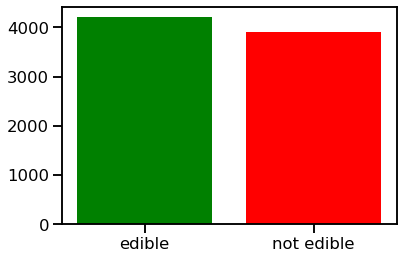

In [7]:
plt.bar(np.arange(2), df['class'].value_counts(), color=['green', 'red'], tick_label=['edible','not edible'])
plt.show()

The data are well balanced between edible and not edible, therefore no resampling is needed.

Finally, I create training and test data sets that will be used for all models

In [8]:
X = df_scaled.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

### Logistic regression

In [9]:
lr_model = LogisticRegression(random_state=123, max_iter=10000)

I use `GridSearchCV` to find the best hyperparameters

In [10]:
params_grid = {'penalty':['l1','l2'], 'solver':['liblinear','saga'], 'C':[0.01,0.1,1,10]}
grid_search = GridSearchCV(estimator=lr_model, param_grid=params_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

Logistic regression already does a decent job, reaching a f1-score of 0.95

In [11]:
print(classification_report(y_test, y_pred, target_names=['edible','not edible']))

              precision    recall  f1-score   support

      edible       0.94      0.96      0.95      1263
  not edible       0.96      0.93      0.94      1175

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438



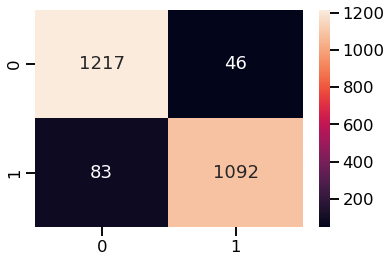

In [12]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

### Support Vector Machines (SVM)

I will try first with a linear SVM model, then I will use a kernel

In [13]:
svl_model = LinearSVC(random_state=123, max_iter=10000)
params_grid = {'C':[0.01,0.1,1,10]}
grid_search = GridSearchCV(estimator=svl_model, param_grid=params_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_params_

{'C': 0.1}

The linear model performance is slightly worse than logistic regression, although the recall on the edible mushrooms is better

In [14]:
print(classification_report(y_test, y_pred, target_names=['edible','not edible']))

              precision    recall  f1-score   support

      edible       0.93      0.97      0.95      1263
  not edible       0.96      0.92      0.94      1175

    accuracy                           0.94      2438
   macro avg       0.94      0.94      0.94      2438
weighted avg       0.94      0.94      0.94      2438



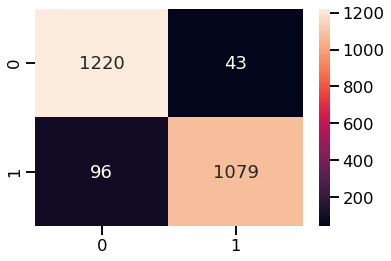

In [15]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [16]:
svk_model = SVC()
params_grid = {'C':[0.01,0.1,1,10], 'kernel':['rbf','sigmoid','poly']}
grid_search = GridSearchCV(estimator=svk_model, param_grid=params_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_params_

{'C': 1, 'kernel': 'rbf'}

On the other hand, the SVM model with the kernel trick does a perfect job. Note that the default parameters were chosen as the best ones.

In [17]:
print(classification_report(y_test, y_pred, target_names=['edible','not edible']))

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1263
  not edible       1.00      1.00      1.00      1175

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



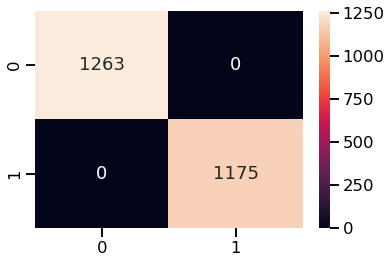

In [18]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

### Decision Tree

In [19]:
dt_model = DecisionTreeClassifier(random_state=123)
params_grid = {
    'max_depth': [3, 5, 10],
    'max_features': [2, 4, 6],
    'min_samples_split': [2, 5]
    }
grid_search = GridSearchCV(estimator=dt_model, param_grid=params_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
grid_search.best_params_

{'max_depth': 10, 'max_features': 4, 'min_samples_split': 2}

Even a relatively simple decision tree can get perfect predictions

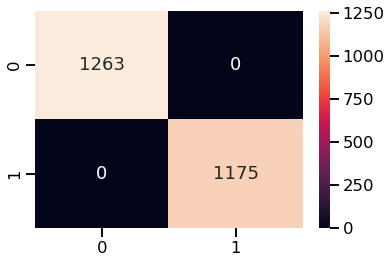

In [20]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

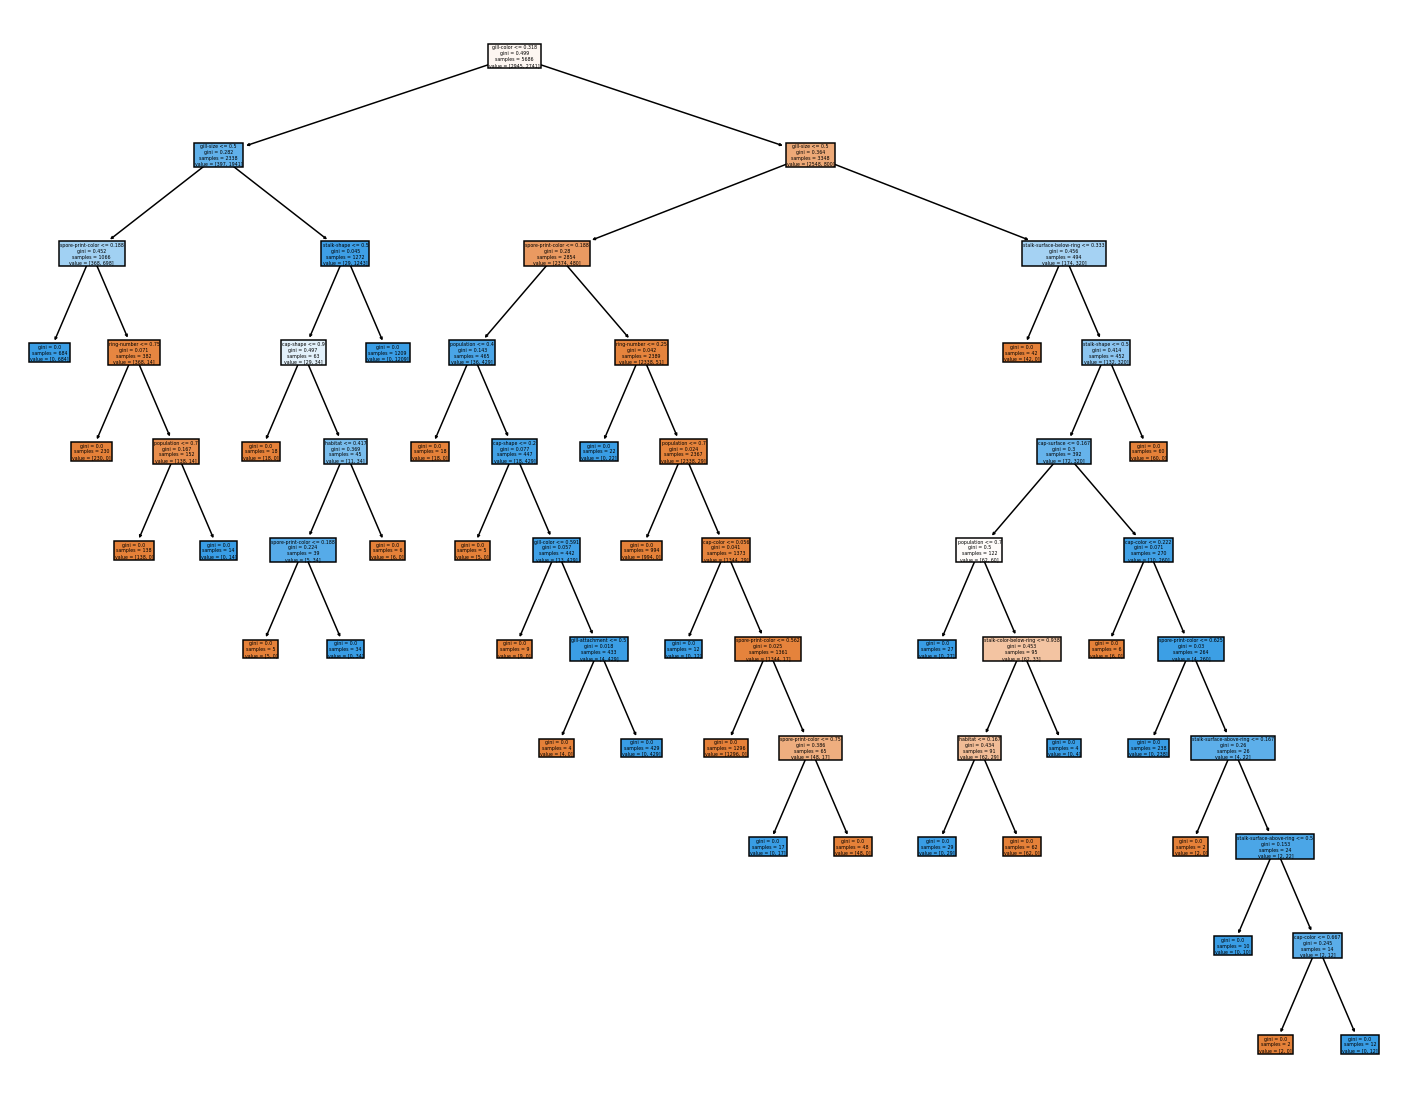

In [21]:
dt_model = DecisionTreeClassifier(random_state=123, max_depth=10, max_features=4)
dt_model.fit(X_train, y_train)
plt.subplots(figsize=(25, 20))
plot_tree(dt_model, feature_names=X_train.columns, filled=True)
plt.show()

### Feature importance

The `DecisionTreeClassifier` class has an attribute that provides the Gini importance of each feature. I will order the features by importance and plot the ten most important in a barplot

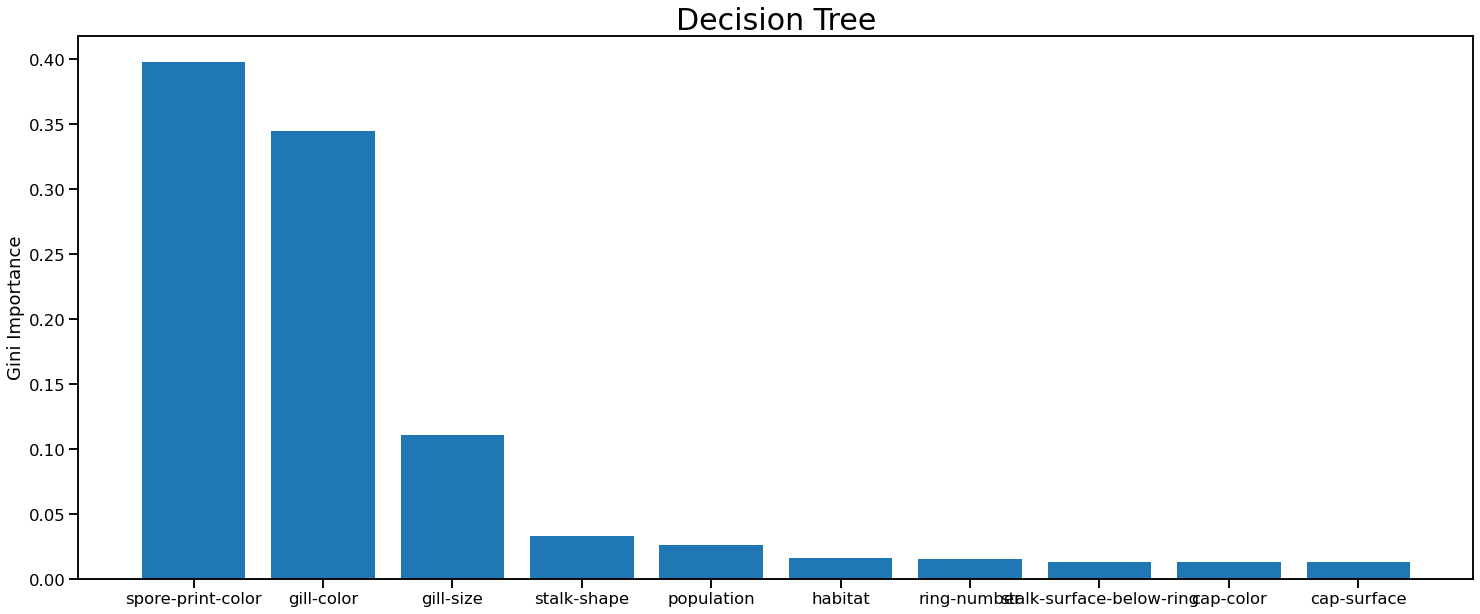

In [22]:
importances = dt_model.feature_importances_
new_order = np.flip(importances.argsort())[:10]
plt.subplots(figsize=(25, 10))
plt.bar(np.arange(10), importances[new_order], tick_label=X_train.columns[new_order])
plt.ylabel('Gini Importance')
plt.title('Decision Tree', fontsize=30)
plt.show()

It appears that spore print and gill colors are by far the most important features, followed by gill size.

By using **permutation feature importance**, a model-agnostic method, gill size becomes the most important feature

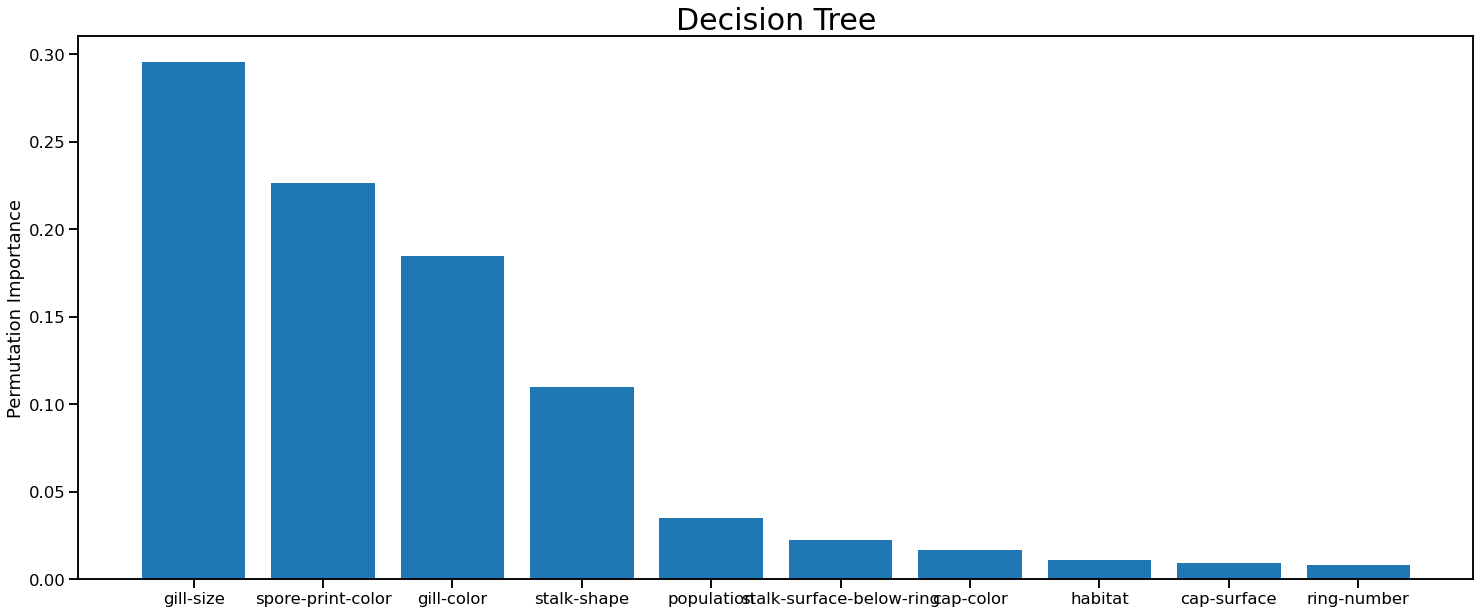

In [23]:
feature_importances = permutation_importance(estimator=dt_model, X=X_train, y=y_train, n_repeats=5,
                                             random_state=123, n_jobs=2).importances_mean
new_order = np.flip(feature_importances.argsort())[:10]
plt.subplots(figsize=(25, 10))
plt.bar(np.arange(10), feature_importances[new_order], tick_label=X_train.columns[new_order])
plt.ylabel('Permutation Importance')
plt.title('Decision Tree', fontsize=30)
plt.show()

For the SVM classification model, however, the most important feature is gill spacing, which was not important at all for the decision tree!

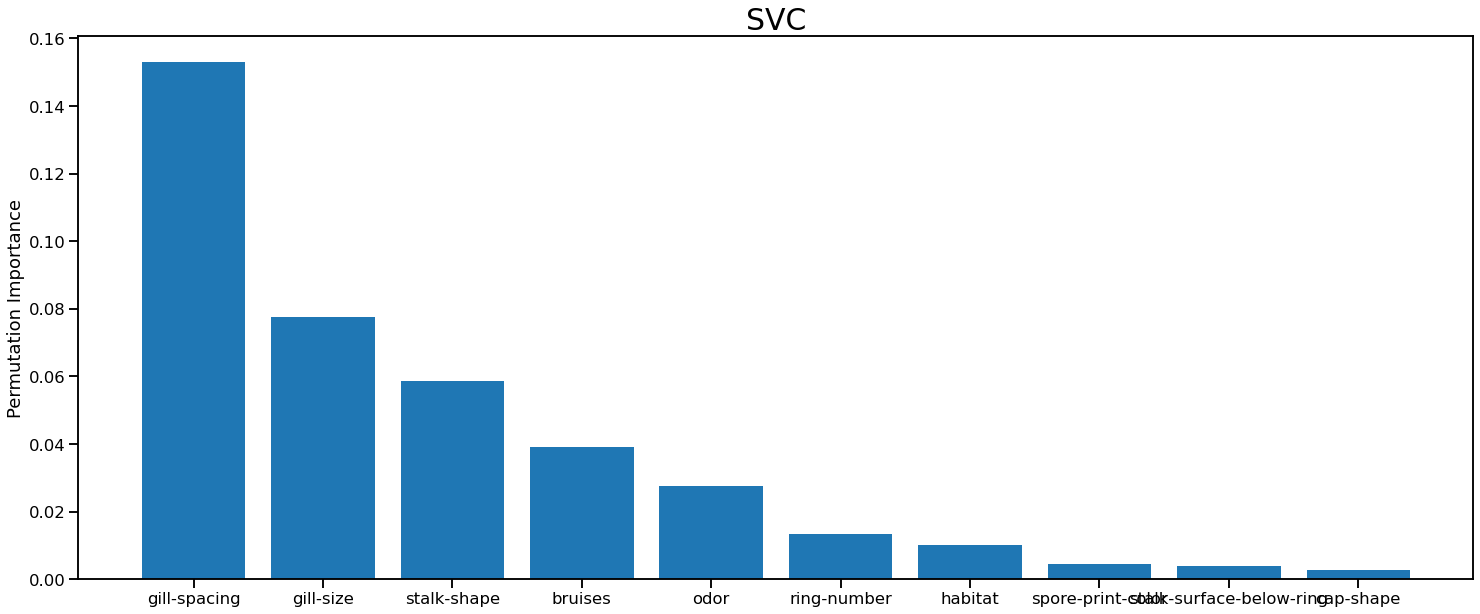

In [24]:
svk_model.fit(X_train, y_train)
feature_importances = permutation_importance(estimator=svk_model, X=X_train, y=y_train, n_repeats=5,
                                             random_state=123, n_jobs=2).importances_mean
new_order = np.flip(feature_importances.argsort())[:10]
plt.subplots(figsize=(25, 10))
plt.bar(np.arange(10), feature_importances[new_order], tick_label=X_train.columns[new_order])
plt.ylabel('Permutation Importance')
plt.title('SVC', fontsize=30)
plt.show()